# **PROJECT: Stock Price Forecasting**

# **Objective**"

#The problem is to forecast the future stock prices of Titan company based on historical data. The dataset contains columns for 'Date,' 'Open,' 'High,' 'Low,' 'Close,' 'Adj Close,' and 'Volume.' The objective is to develop an accurate time series forecasting model to predict future stock prices, facilitating investment decisions and risk management."

In [1]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.9 MB/s eta 0:00:00


# **Import the Libraries**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from scipy.stats import mstats
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam



# **EDA**

##Reading the Data

In [3]:
data=pd.read_excel("/content/TITAN NEW.xlsx")

In [4]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-01,1194.449951,1199.000000,1152.199951,1154.750000,1139.831177,3137636
1,2020-01-02,1157.000000,1159.900024,1140.000000,1155.599976,1140.670166,3286436
2,2020-01-03,1156.000000,1156.000000,1132.000000,1139.699951,1124.975464,2695237
3,2020-01-06,1162.000000,1171.400024,1150.099976,1158.599976,1143.631348,4494752
4,2020-01-07,1170.949951,1173.849976,1152.050049,1159.949951,1144.963745,2363578


In [5]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
960,2023-11-13,3275.000000,3278.350098,3250.600098,3264.750000,3264.750000,275538
961,2023-11-15,3275.250000,3300.899902,3260.750000,3295.949951,3295.949951,747863
962,2023-11-16,3295.399902,3358.000000,3259.250000,3335.949951,3335.949951,1055389
963,2023-11-17,3339.000000,3366.000000,3326.699951,3338.850098,3338.850098,633405
964,2023-11-20,3338.000000,3353.949951,3312.250000,3345.850098,3345.850098,497379


##Non Null Counts and Datatypes

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965 entries, 0 to 964
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       965 non-null    datetime64[ns]
 1   Open       965 non-null    float64       
 2   High       965 non-null    float64       
 3   Low        965 non-null    float64       
 4   Close      965 non-null    float64       
 5   Adj Close  965 non-null    float64       
 6   Volume     965 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 52.9 KB


##Deleting unnecessary columns

In [7]:
data=data.drop(columns=["Open",	"High",	"Low", "Adj Close",	"Volume"	])

##Indexing

In [8]:
data['Date'] = pd.to_datetime(data['Date'])

# Set 'date_column' as the index
data.set_index('Date', inplace=True)

In [9]:
data.head()


,Close
Date,
2020-01-01,1154.750000
2020-01-02,1155.599976
2020-01-03,1139.699951
2020-01-06,1158.599976
2020-01-07,1159.949951


## Data Dimensions

In [10]:
data.shape

(965, 1)

##Data Types

In [11]:
data.dtypes

Close    float64
dtype: object

## Missing Values

In [12]:
null=data.isna().sum()
null

Close    0
dtype: int64

##Unique values

In [13]:
data.nunique()

Close    949
dtype: int64

##Duplicate Data

In [14]:
duplicate = data.duplicated().sum()
print('There are {} duplicated rows in the data'.format(duplicate))

There are 16 duplicated rows in the data


#Data Understanding

##Summary Statistics

In [15]:
data.describe()

,Close
count,965.000000
mean,2038.042071
std,700.310113
min,800.950012
25%,1426.150024
50%,2189.699951
75%,2576.149902
max,3345.850098


##Pivot Table

In [16]:
data1=data.copy()
data1.head()

,Close
Date,
2020-01-01,1154.750000
2020-01-02,1155.599976
2020-01-03,1139.699951
2020-01-06,1158.599976
2020-01-07,1159.949951


In [17]:
data1.reset_index(inplace=True)

In [18]:
data1['Month'] = data1['Date'].dt.month
data1['Year'] = data1['Date'].dt.year

In [19]:
data1.head()

,Date,Close,Month,Year
0,2020-01-01,1154.750000,1,2020
1,2020-01-02,1155.599976,1,2020
2,2020-01-03,1139.699951,1,2020
3,2020-01-06,1158.599976,1,2020
4,2020-01-07,1159.949951,1,2020


In [20]:
data1.set_index('Date', inplace=True)

In [21]:
pivot_table=pd.pivot_table(data=data1,values='Close',index='Year',columns='Month',aggfunc='mean',fill_value=0)
pivot_table

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2020,1176.417380,1277.463154,1037.528567,943.974996,859.244732,974.965909,1008.832597,1112.016665,1152.043185,1223.261893,1285.407489,1470.463634
2021,1514.109998,1480.844995,1481.909517,1520.634207,1499.304999,1715.834090,1719.852388,1834.140474,2069.152408,2384.732483,2445.217517,2354.569559
2022,2531.620007,2464.975000,2549.359503,2498.057900,2171.069045,2076.531822,2183.154762,2462.922485,2638.568182,2652.039487,2652.078567,2556.518177
2023,2441.019066,2446.472510,2437.792864,2594.414694,2738.381803,2924.545236,3039.714297,3017.452259,3218.287525,3232.687475,3278.457707,0.000000


#Outliers

In [22]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Close    1149.999878
dtype: float64


In [23]:
outlier = pd.DataFrame((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))

for i in outlier.columns:
    print('Total number of Outliers in column {} are {}'.format(i, (len(outlier[outlier[i] == True][i]))))

Total number of Outliers in column Close are 0


In [24]:
Q1 = data.quantile(0.25)
lower_tail= Q1 - 1.5 * IQR
lower_tail

Close   -298.849793
dtype: float64

In [25]:
Q3 = data.quantile(0.75)
Upper_tail= Q3 + 1.5 * IQR
Upper_tail

Close    4301.149719
dtype: float64

#Visualization

##Outlier visualization using boxplot

<function matplotlib.pyplot.show(close=None, block=None)>

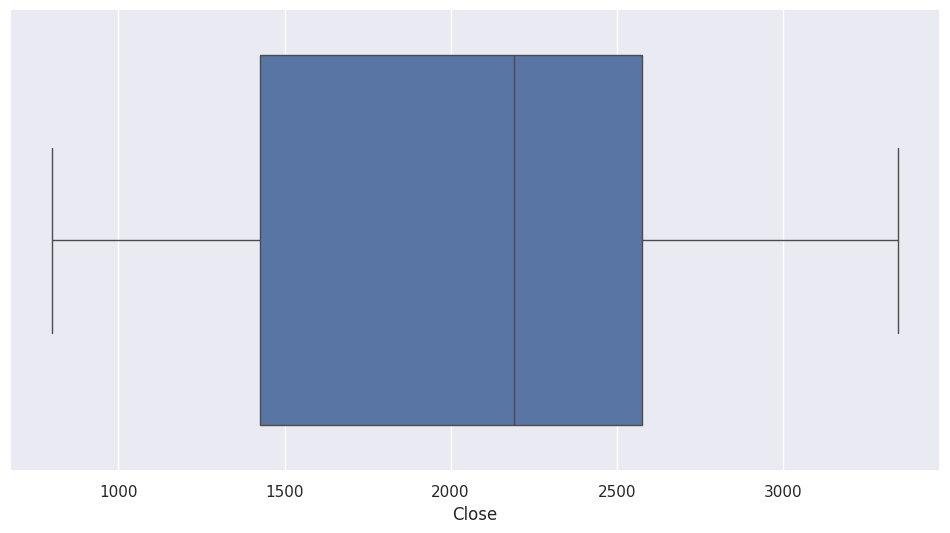

In [26]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")
sns.boxplot(x="Close",data= data)
plt.show

#There are no outliers in our dataset

In [27]:
data.skew()

Close   -0.088473
dtype: float64

##Distplot

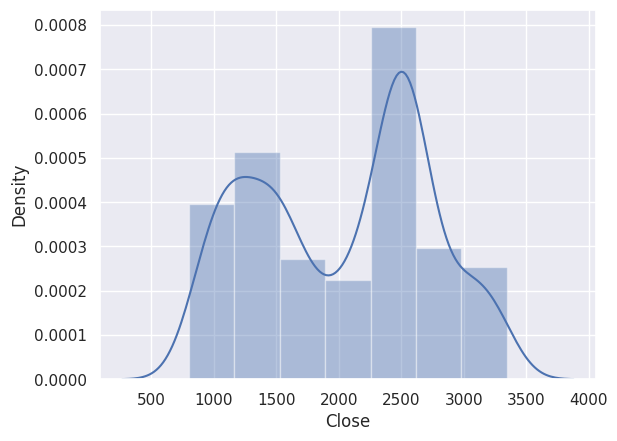

In [28]:
sns.distplot(data['Close'],bins=7, kde=True)
plt.show()

In [29]:
data.mean()

Close    2038.042071
dtype: float64

##Line plot

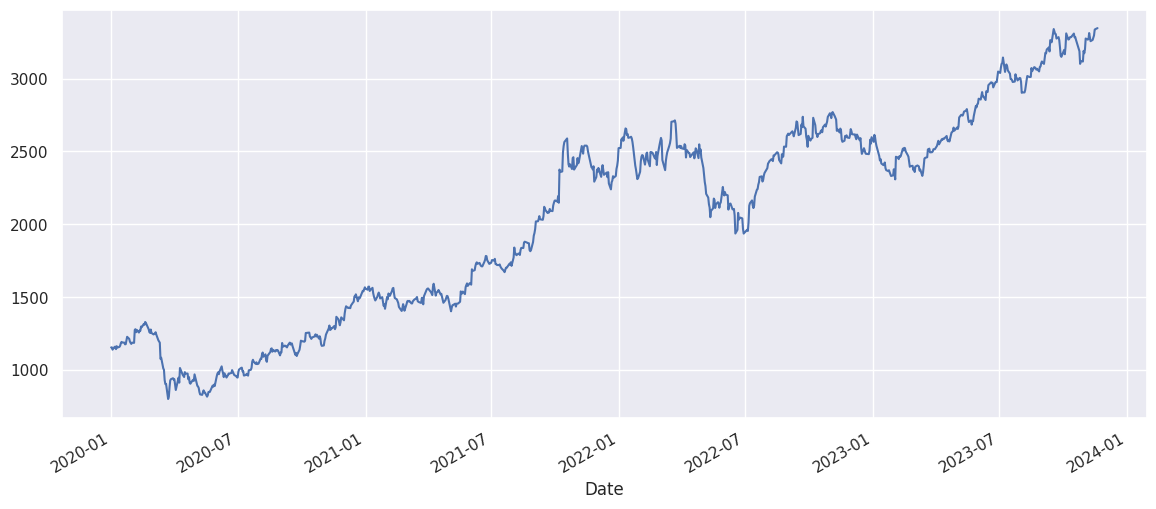

In [30]:
plt.figure(figsize=(12,4))
data['Close'].plot(figsize=(14,6))
plt.show()


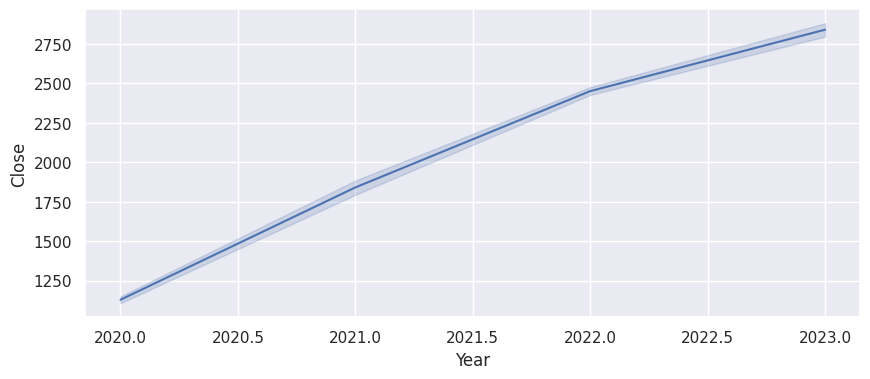

In [31]:
plt.figure(figsize=(10,4))
sns.lineplot(x='Year',y='Close',data=data1)
plt.show()


#Simple Moving Average

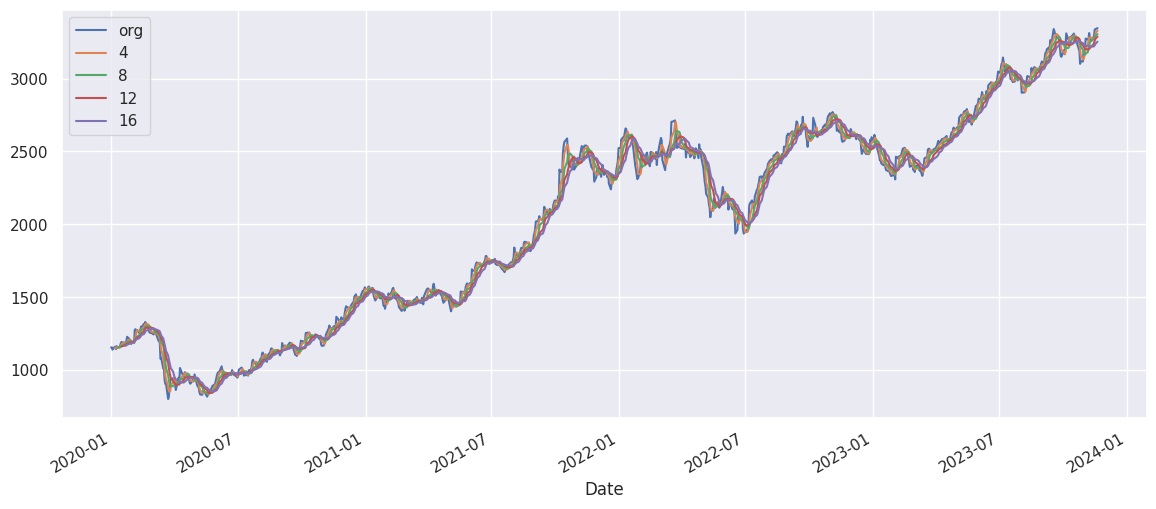

In [32]:
plt.figure(figsize=(14,6))
data.Close.plot(label='org')
for i in range (4,20,4):
  data['Close'].rolling(i).mean().plot(label=str(i))
  plt.legend(loc='best')

#cummulative moving average

<Axes: xlabel='Date'>

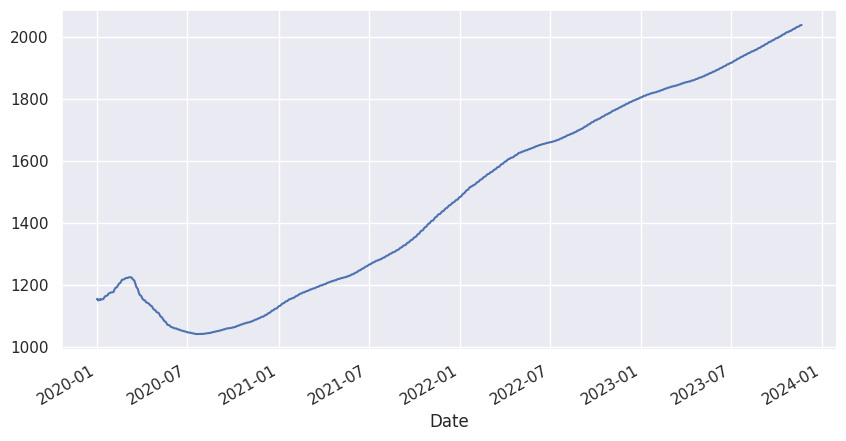

In [33]:
data["Close"].expanding().mean().plot(figsize=(10,5))

##The Cumulative Moving Average (CMA) provides a measure of the average of all data points observed up to a specific time point.
##Here CMA is increasing, which means that the stock prices are also increasing.

#Exponential Moving Average

In [34]:
data["EMA_0.1"]=data["Close"].ewm(alpha=0.1,adjust=False).mean()

<Axes: xlabel='Date'>

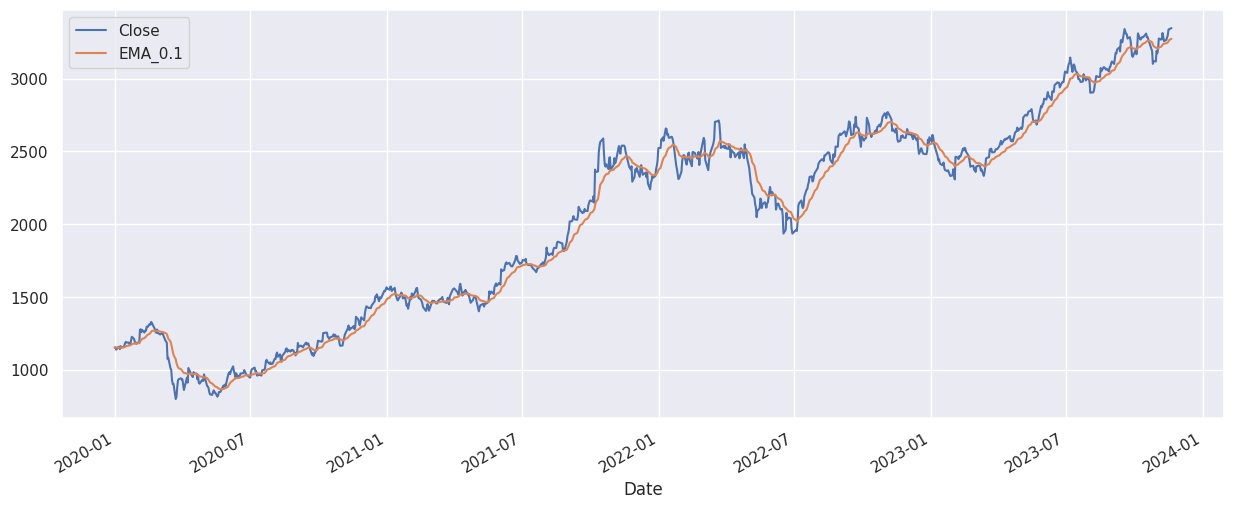

In [35]:
data[["Close","EMA_0.1"]].plot(figsize=(15,6))

In [36]:
data=data.drop(columns=["EMA_0.1"])

##EMA gives higher weghts to the most recent data rather than the old one.
##Done to prevent any lags

#Time Series Decomposition

<Figure size 640x480 with 0 Axes>

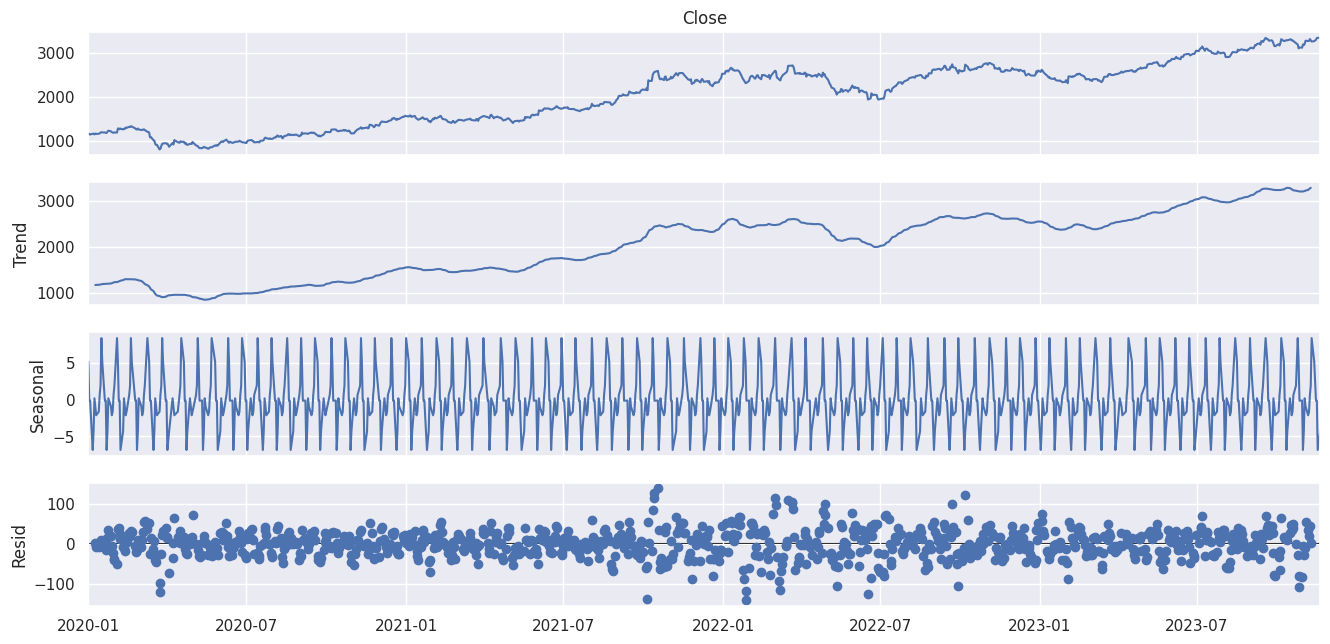

In [37]:
#seasonal decompose

decomposition = seasonal_decompose(data['Close'], model='additive', period=12)  # Seasonal Decomposition of Time Series
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 7)
plt.show()


##The trend component represents the long-term pattern or direction of the data, ignoring any short-term fluctuations or seasonality.
##The seasonal component captures regular, repeating patterns or cycles within the data that occur at fixed intervals.
##The residual component represents the random fluctuations or irregularities in the data that cannot be explained by the trend or seasonal components.

#Stationarity Test
##Augmented Dickey Fuller Test

In [38]:
from statsmodels.tsa.stattools import adfuller

In [39]:
data2=data.copy()
data2

,Close
Date,
2020-01-01,1154.750000
2020-01-02,1155.599976
2020-01-03,1139.699951
2020-01-06,1158.599976
2020-01-07,1159.949951
...,...
2023-11-13,3264.750000
2023-11-15,3295.949951
2023-11-16,3335.949951


In [40]:
result = adfuller(data2['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

ADF Statistic: -0.14615171622542988
p-value: 0.9446431745064727
Critical Values: {'1%': -3.437151658028634, '5%': -2.8645428373470563, '10%': -2.5683688733406793}


In [41]:
if result[1] <= 0.05:
    print("Reject the null hypothesis. The data is stationary.")
else:
    print("Fail to reject the null hypothesis. The data is non-stationary.")

Fail to reject the null hypothesis. The data is non-stationary.


#The data appears to be non-stationary according to the ADF test.

##Differencing

In [42]:
#Differencing
data2['Close 1st difference']=data2['Close']-data2['Close'].shift(1) #Differencing
def adf_test(timeseries):
    result = adfuller(timeseries.dropna(), autolag='AIC')
    print('ADF Statistic:', result[1])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    if result[1] <= 0.05:
        print("Result: Stationary (Reject the null hypothesis)")
    else:
        print("Result: Non-Stationary (Fail to reject the null hypothesis)")


# Perform ADF test
adf_test(data2['Close 1st difference'])

ADF Statistic: 0.0
p-value: 0.0
Critical Values: {'1%': -3.4371587399783072, '5%': -2.8645459603872903, '10%': -2.568370536787406}
Result: Stationary (Reject the null hypothesis)


In [43]:
data2["close 12 differencing"]=data2['Close']-data2['Close'].shift(12)

In [44]:
adf_test(data2["close 12 differencing"].dropna())

ADF Statistic: 3.543657598758967e-07
p-value: 3.543657598758967e-07
Critical Values: {'1%': -3.437385839245221, '5%': -2.8646461040926496, '10%': -2.5684238776271435}
Result: Stationary (Reject the null hypothesis)


#The data appears to be stationary after differencing

In [45]:
data2.isna().sum()

Close                     0
Close 1st difference      1
close 12 differencing    12
dtype: int64

In [46]:
data2=data2.dropna()

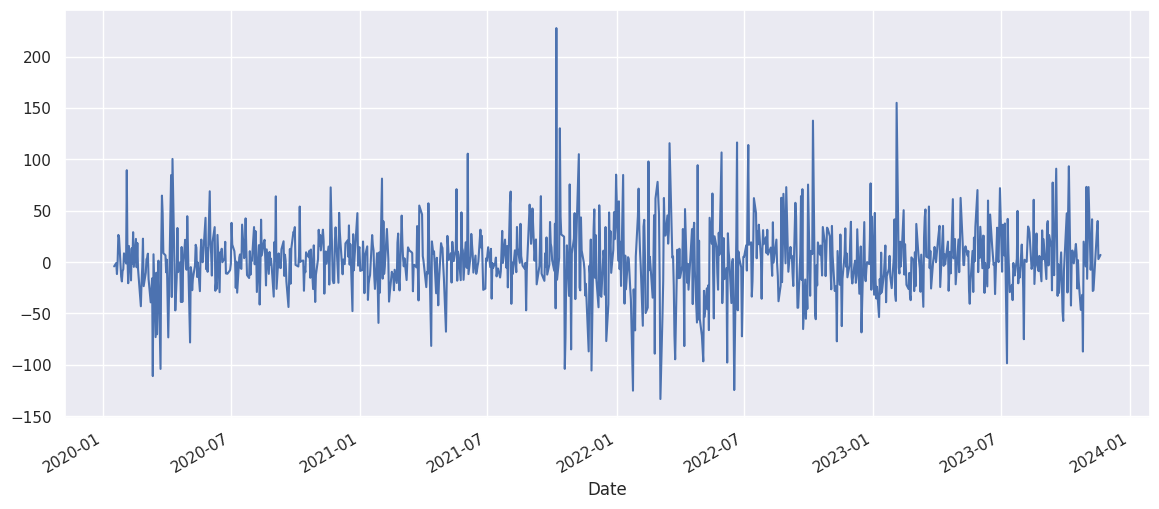

In [47]:
plt.figure(figsize=(10,4))
data2['Close 1st difference'].plot(figsize=(14,6))
plt.show()

##ACF and PACF Plot

ACF and the PACF plots provides the correlation between observations at different lags

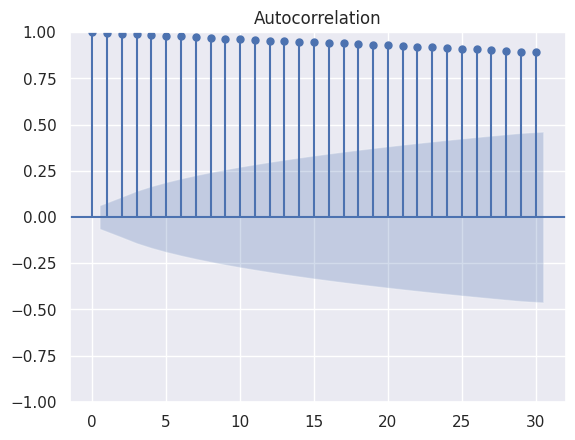

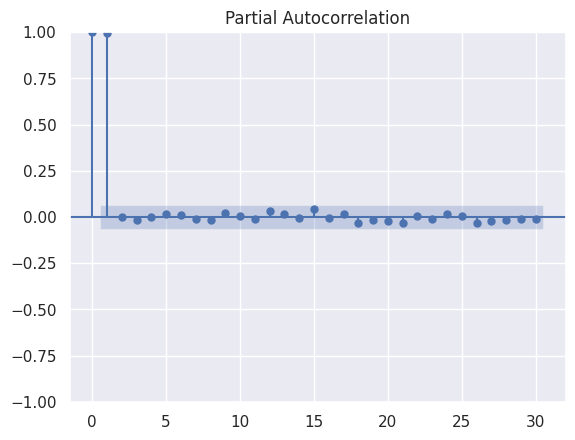

In [48]:
acf=plot_acf(data2['Close'].dropna())
pacf=plot_pacf(data2["Close"].dropna())

ACF-PACF Plot of close 1st differencing

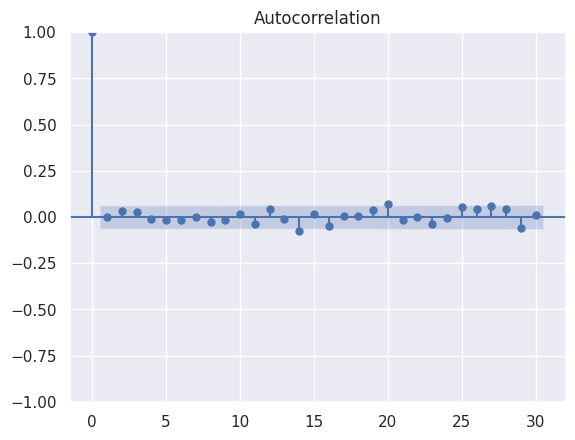

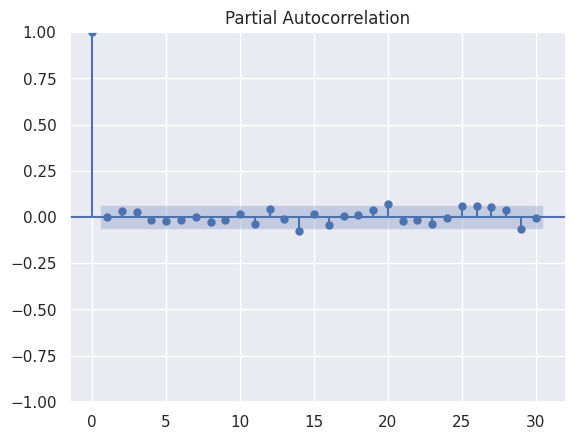

In [49]:
acf=plot_acf(data2['Close 1st difference'].dropna())
pacf=plot_pacf(data2["Close 1st difference"].dropna())


ACF-PACF Plot of close 12th differencing

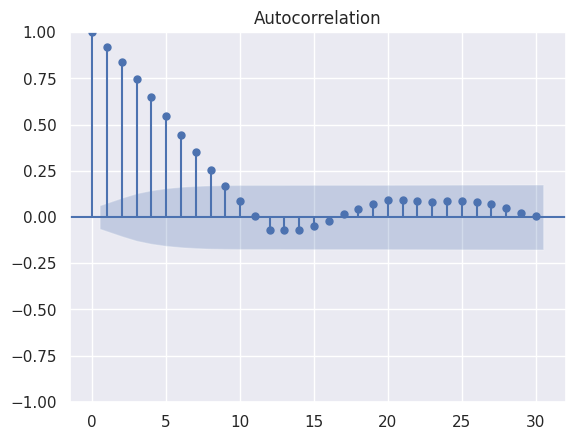

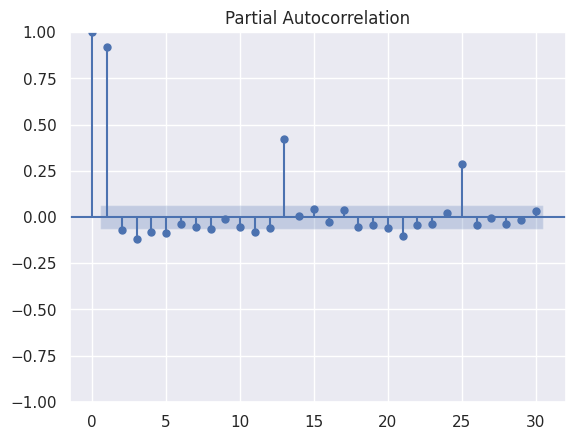

In [50]:
acf2=plot_acf(data2['close 12 differencing'].dropna())
pacf=plot_pacf(data2["close 12 differencing"].dropna())

#ARIMA-SARIMA

In [51]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [52]:
data2=data2.dropna()
data2

,Close,Close 1st difference,close 12 differencing
Date,,,
2020-01-17,1188.750000,-4.150024,34.000000
2020-01-20,1187.849976,-0.900024,32.250000
2020-01-21,1176.199951,-11.650025,36.500000
2020-01-22,1177.650024,1.450073,19.050048
2020-01-23,1204.099976,26.449952,44.150025
...,...,...,...
2023-11-13,3264.750000,8.399902,163.949951
2023-11-15,3295.949951,31.199951,175.250000
2023-11-16,3335.949951,40.000000,219.500000


In [53]:
train_data=data2.iloc[:700]
test_data=data2.iloc[700:]

In [54]:
train_data

,Close,Close 1st difference,close 12 differencing
Date,,,
2020-01-17,1188.750000,-4.150024,34.000000
2020-01-20,1187.849976,-0.900024,32.250000
2020-01-21,1176.199951,-11.650025,36.500000
2020-01-22,1177.650024,1.450073,19.050048
2020-01-23,1204.099976,26.449952,44.150025
...,...,...,...
2022-11-04,2769.699951,6.050049,128.599853
2022-11-07,2741.550049,-28.149902,97.000000
2022-11-09,2718.100098,-23.449951,86.600098


In [55]:
test_data

,Close,Close 1st difference,close 12 differencing
Date,,,
2022-11-14,2629.800049,-22.000000,-40.500000
2022-11-15,2656.649902,26.849853,-47.150147
2022-11-16,2644.300049,-12.349853,-92.099853
2022-11-17,2582.000000,-62.300049,-179.500000
2022-11-18,2565.800049,-16.199951,-189.149902
...,...,...,...
2023-11-13,3264.750000,8.399902,163.949951
2023-11-15,3295.949951,31.199951,175.250000
2023-11-16,3335.949951,40.000000,219.500000


##ARIMA 1st differencing

In [56]:
auto_model = auto_arima(train_data["Close 1st difference"], trace=True, suppress_warnings=True)
best_order = auto_model.order
print(f'Best ARIMA Order (auto): {best_order}')

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.69 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=7002.575, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7004.385, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7004.395, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7002.934, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=7006.156, Time=0.67 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.691 seconds
Best ARIMA Order (auto): (0, 0, 0)


In [57]:
order = (0,0,0)
arimamodel = ARIMA(train_data['Close 1st difference'], order=order)
arima_model = arimamodel.fit()

In [58]:
# Forecasting
num_periods = len(test_data)
forecast = arima_model.forecast(steps=num_periods)

last_observed_value = train_data['Close'].iloc[-1]
forecast_test_data = np.cumsum(forecast) + last_observed_value


In [59]:
forecast_test_data

700    2653.884187
701    2655.968325
702    2658.052463
703    2660.136600
704    2662.220738
          ...     
948    3170.750379
949    3172.834517
950    3174.918655
951    3177.002792
952    3179.086930
Name: predicted_mean, Length: 253, dtype: float64

In [60]:
rmse_arima = np.sqrt(mean_squared_error(test_data["Close"], forecast_test_data))
print("RMSE:", rmse_arima)

RMSE: 215.4130361317084


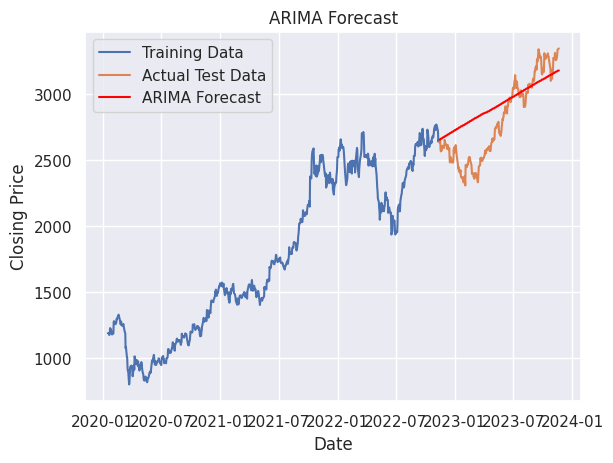

In [61]:
plt.plot(train_data.index, train_data['Close'], label='Training Data')
plt.plot(test_data.index, test_data['Close'], label='Actual Test Data')
plt.plot(test_data.index, forecast_test_data, label='ARIMA Forecast', color='red')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [62]:
start = len(train_data) + len(test_data)
end = start + 29
pred_arima_next_30_days = arima_model.predict(start=start, end=end)

In [63]:
last_observed_value = forecast_test_data.iloc[-1]
forecast_30_arima = np.cumsum(pred_arima_next_30_days) + last_observed_value
forecast_index = pd.date_range(start=test_data.index[-1], periods=30, freq='B')
forecast_30_arima.index = forecast_index

In [64]:
forecast_30_arima

2023-11-20    3181.171068
2023-11-21    3183.255206
2023-11-22    3185.339344
2023-11-23    3187.423482
2023-11-24    3189.507620
2023-11-27    3191.591758
2023-11-28    3193.675895
2023-11-29    3195.760033
2023-11-30    3197.844171
2023-12-01    3199.928309
2023-12-04    3202.012447
2023-12-05    3204.096585
2023-12-06    3206.180723
2023-12-07    3208.264861
2023-12-08    3210.348998
2023-12-11    3212.433136
2023-12-12    3214.517274
2023-12-13    3216.601412
2023-12-14    3218.685550
2023-12-15    3220.769688
2023-12-18    3222.853826
2023-12-19    3224.937963
2023-12-20    3227.022101
2023-12-21    3229.106239
2023-12-22    3231.190377
2023-12-25    3233.274515
2023-12-26    3235.358653
2023-12-27    3237.442791
2023-12-28    3239.526929
2023-12-29    3241.611066
Freq: B, Name: predicted_mean, dtype: float64

##SARIMAX on actual data

In [65]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_sarimax = SARIMAX(train_data['Close'], order=(1,1,2),seasonal_order=(1,1,2,12))
model_fit = model_sarimax.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                  700
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 12)   Log Likelihood               -3460.752
Date:                            Mon, 01 Apr 2024   AIC                           6935.505
Time:                                    14:44:18   BIC                           6967.231
Sample:                                         0   HQIC                          6947.779
                                            - 700                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0774      0.978      0.079      0.937      -1.840       1.995
ma.L1         -0.0634      0.976     -0.065      0.948      -1.977       1.850
ma.L2          0.0294      0.038      0.766      0.444      -0.046       0.105
ar.S.L12      -0.9878      0.143     -6.896      0.000      -1.269      -0.707
ma.S.L12      -0.0052     85.396  -6.04e-05      1.000    -167.378     167.368
ma.S.L24      -0.9948     84.865     -0.012      0.991    -167.327     165.338
sigma2      1292.4643    1.1e+05      0.012      0.991   -2.15e+05    2.17e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               384.85
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               2.57   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
start = len(train_data)
end = len(train_data)+len(test_data)-1
print(start,end)
pred_sarima = model_fit.predict(start=start, end=end)


700 952


In [67]:
sarima_rmse = np.sqrt(mean_squared_error(test_data['Close'], pred_sarima))
print('SARIMA RMSE:', sarima_rmse)

SARIMA RMSE: 218.47911380105765


In [68]:
pred_sarima

700    2655.907181
701    2660.324003
702    2660.280305
703    2664.822327
704    2663.731080
          ...     
948    3187.172581
949    3183.798028
950    3184.382190
951    3179.138216
952    3187.169802
Name: predicted_mean, Length: 253, dtype: float64

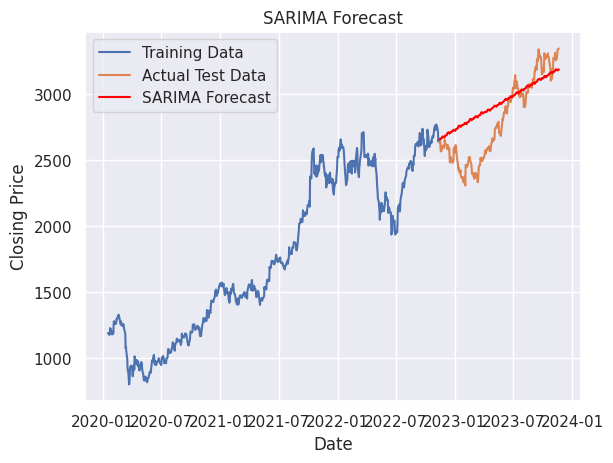

In [69]:
plt.plot(train_data.index, train_data["Close"], label='Training Data')
plt.plot(test_data.index, test_data['Close'], label='Actual Test Data')
plt.plot(test_data.index, pred_sarima, label='SARIMA Forecast', color='red')
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [70]:
start = len(train_data) + len(test_data)
end = start + 29
pred_sarima_next_30_days = model_fit.predict(start=start, end=end)
forecast_index = pd.date_range(start=test_data.index[-1], periods=30, freq='B')
pred_sarima_next_30_days.index = forecast_index

In [71]:
pred_sarima_next_30_days

2023-11-20    3192.205050
2023-11-21    3192.854326
2023-11-22    3195.024317
2023-11-23    3195.790217
2023-11-24    3201.191061
2023-11-27    3208.860794
2023-11-28    3214.335482
2023-11-29    3217.506731
2023-11-30    3215.198177
2023-12-01    3213.496110
2023-12-04    3207.993747
2023-12-05    3214.401075
2023-12-06    3218.576982
2023-12-07    3218.600550
2023-12-08    3222.824727
2023-12-11    3221.980665
2023-12-12    3225.581209
2023-12-13    3230.774866
2023-12-14    3237.691877
2023-12-15    3237.994141
2023-12-18    3234.632562
2023-12-19    3235.188899
2023-12-20    3229.941780
2023-12-21    3237.953597
2023-12-22    3242.978387
2023-12-25    3243.620047
2023-12-26    3245.815040
2023-12-27    3246.561345
2023-12-28    3251.940278
2023-12-29    3259.579875
Freq: B, Name: predicted_mean, dtype: float64

#Linear, Exponential, Quadratic Models

In [72]:
data1.head()

,Close,Month,Year
Date,,,
2020-01-01,1154.750000,1,2020
2020-01-02,1155.599976,1,2020
2020-01-03,1139.699951,1,2020
2020-01-06,1158.599976,1,2020
2020-01-07,1159.949951,1,2020


In [73]:
data1['t'] = np.arange(1,len(data1)+1)
data1['t_squared'] = np.square(data1.t)

In [74]:
data1['log_Close'] = np.log(data1['Close'])
data1

,Close,Month,Year,t,t_squared,log_Close
Date,,,,,,
2020-01-01,1154.750000,1,2020,1,1,7.051639
2020-01-02,1155.599976,1,2020,2,4,7.052375
2020-01-03,1139.699951,1,2020,3,9,7.038520
2020-01-06,1158.599976,1,2020,4,16,7.054968
2020-01-07,1159.949951,1,2020,5,25,7.056132
...,...,...,...,...,...,...
2023-11-13,3264.750000,11,2023,961,923521,8.090938
2023-11-15,3295.949951,11,2023,962,925444,8.100450
2023-11-16,3335.949951,11,2023,963,927369,8.112513


In [75]:
train_data=data1.iloc[:700]
test_data=data1.iloc[700:]

In [76]:
train_data

,Close,Month,Year,t,t_squared,log_Close
Date,,,,,,
2020-01-01,1154.750000,1,2020,1,1,7.051639
2020-01-02,1155.599976,1,2020,2,4,7.052375
2020-01-03,1139.699951,1,2020,3,9,7.038520
2020-01-06,1158.599976,1,2020,4,16,7.054968
2020-01-07,1159.949951,1,2020,5,25,7.056132
...,...,...,...,...,...,...
2022-10-18,2641.100098,10,2022,696,484416,7.878951
2022-10-19,2644.550049,10,2022,697,485809,7.880256
2022-10-20,2631.500000,10,2022,698,487204,7.875309


In [77]:
test_data

,Close,Month,Year,t,t_squared,log_Close
Date,,,,,,
2022-10-25,2670.300049,10,2022,701,491401,7.889946
2022-10-27,2703.800049,10,2022,702,492804,7.902413
2022-10-28,2736.399902,10,2022,703,494209,7.914398
2022-10-31,2761.500000,10,2022,704,495616,7.923529
2022-11-01,2754.949951,11,2022,705,497025,7.921155
...,...,...,...,...,...,...
2023-11-13,3264.750000,11,2023,961,923521,8.090938
2023-11-15,3295.949951,11,2023,962,925444,8.100450
2023-11-16,3335.949951,11,2023,963,927369,8.112513


##Linear Model

In [78]:
import statsmodels.formula.api as smf
linear_model1=smf.ols('Close~t',data=train_data).fit()
pred_linear=pd.Series(linear_model1.predict(pd.DataFrame(test_data['t'])))
rmse_linear1=np.sqrt(np.mean((np.array(test_data['Close'])-np.array(pred_linear))**2))
print('rmse_linear1 :',rmse_linear1)

rmse_linear1 : 288.36021525209117


In [79]:
linear_model=smf.ols('log_Close~t',data=train_data).fit()
pred_linear=pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear=np.sqrt(np.mean((np.array(test_data['log_Close'])-np.array(pred_linear))**2))
print("rmse_linear:",rmse_linear)

rmse_linear: 0.2591668058142757


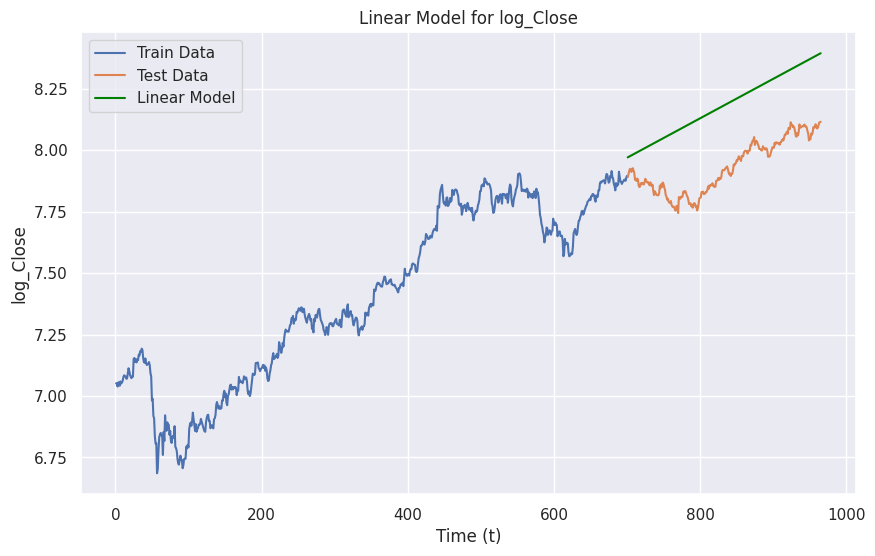

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(train_data['t'], train_data['log_Close'], label='Train Data')
plt.plot(test_data['t'], test_data['log_Close'], label='Test Data')
plt.plot(test_data['t'], pred_linear, color='green', label='Linear Model')
plt.title('Linear Model for log_Close')
plt.xlabel('Time (t)')
plt.ylabel('log_Close')
plt.legend()
plt.show()

In [81]:
pred_linear, test_data["log_Close"]

(Date
 2022-10-25    7.970726
 2022-10-27    7.972330
 2022-10-28    7.973935
 2022-10-31    7.975539
 2022-11-01    7.977143
                 ...   
 2023-11-13    8.387869
 2023-11-15    8.389474
 2023-11-16    8.391078
 2023-11-17    8.392682
 2023-11-20    8.394287
 Length: 265, dtype: float64,
 Date
 2022-10-25    7.889946
 2022-10-27    7.902413
 2022-10-28    7.914398
 2022-10-31    7.923529
 2022-11-01    7.921155
                 ...   
 2023-11-13    8.090938
 2023-11-15    8.100450
 2023-11-16    8.112513
 2023-11-17    8.113382
 2023-11-20    8.115476
 Name: log_Close, Length: 265, dtype: float64)

In [82]:
Date = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=19, freq='D')
future_time_points = np.arange(test_data['t'].iloc[-1] + 1, test_data['t'].iloc[-1] + 20)
pred_future_linear = linear_model.predict(pd.DataFrame(future_time_points, columns=['t']))

In [83]:
future_predictions_df = pd.DataFrame({'Date': Date, 'Predictions': pred_future_linear})
future_predictions_df.set_index('Date', inplace=True)
print(future_predictions_df)
future_predictions_df=np.exp(future_predictions_df)
print(future_predictions_df)

            Predictions
Date                   
2023-11-21     8.395891
2023-11-22     8.397496
2023-11-23     8.399100
2023-11-24     8.400704
2023-11-25     8.402309
2023-11-26     8.403913
2023-11-27     8.405518
2023-11-28     8.407122
2023-11-29     8.408726
2023-11-30     8.410331
2023-12-01     8.411935
2023-12-02     8.413540
2023-12-03     8.415144
2023-12-04     8.416748
2023-12-05     8.418353
2023-12-06     8.419957
2023-12-07     8.421562
2023-12-08     8.423166
2023-12-09     8.424770
            Predictions
Date                   
2023-11-21  4428.831994
2023-11-22  4435.943304
2023-11-23  4443.066034
2023-11-24  4450.200200
2023-11-25  4457.345821
2023-11-26  4464.502916
2023-11-27  4471.671503
2023-11-28  4478.851601
2023-11-29  4486.043227
2023-11-30  4493.246401
2023-12-01  4500.461141
2023-12-02  4507.687466
2023-12-03  4514.925394
2023-12-04  4522.174943
2023-12-05  4529.436133
2023-12-06  4536.708983
2023-12-07  4543.993510
2023-12-08  4551.289734
2023-12-09  4558

##Holt-Winter's Exponential Smoothing

In [84]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
expmodel = ExponentialSmoothing(train_data['log_Close'], trend='add', seasonal='add', seasonal_periods=12)
HWmodel_fit = expmodel.fit()
pred = HWmodel_fit.forecast(len(test_data)).rename('Exponential Smoothing')
pred.index = test_data.index

In [85]:
rmse_exp = np.sqrt(mean_squared_error(test_data['log_Close'], pred))
print("The root mean squared error is:", rmse_exp)

The root mean squared error is: 0.14144038330414774


In [86]:
pred, test_data["log_Close"]

(Date
 2022-10-25    7.898914
 2022-10-27    7.902277
 2022-10-28    7.902200
 2022-10-31    7.904253
 2022-11-01    7.902848
                 ...   
 2023-11-13    8.221321
 2023-11-15    8.218696
 2023-11-16    8.219015
 2023-11-17    8.216322
 2023-11-20    8.220209
 Name: Exponential Smoothing, Length: 265, dtype: float64,
 Date
 2022-10-25    7.889946
 2022-10-27    7.902413
 2022-10-28    7.914398
 2022-10-31    7.923529
 2022-11-01    7.921155
                 ...   
 2023-11-13    8.090938
 2023-11-15    8.100450
 2023-11-16    8.112513
 2023-11-17    8.113382
 2023-11-20    8.115476
 Name: log_Close, Length: 265, dtype: float64)

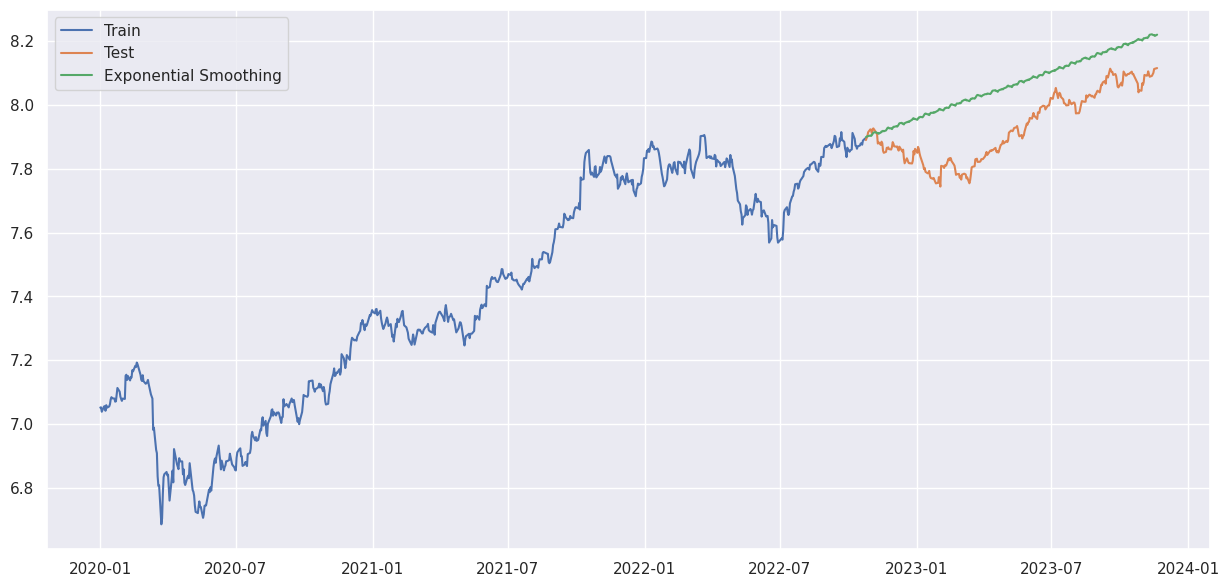

In [87]:
plt.figure(figsize=(15,7))
plt.plot(train_data['log_Close'], label='Train')
plt.plot(test_data['log_Close'], label='Test')
plt.plot(pred, label='Exponential Smoothing')
plt.legend(loc='best')
plt.show()

In [88]:
forecast_length = 30
forecast_index = pd.date_range(start=test_data.index[-5], periods=forecast_length, freq='B')  # Generate date range for forecast
forecast_exp = HWmodel_fit.forecast(forecast_length)
forecast_exp.index = forecast_index

In [89]:
forecast_exp

2023-11-13    7.898914
2023-11-14    7.902277
2023-11-15    7.902200
2023-11-16    7.904253
2023-11-17    7.902848
2023-11-20    7.905452
2023-11-21    7.909559
2023-11-22    7.913260
2023-11-23    7.914630
2023-11-24    7.912004
2023-11-27    7.912323
2023-11-28    7.909631
2023-11-29    7.913518
2023-11-30    7.916881
2023-12-01    7.916804
2023-12-04    7.918857
2023-12-05    7.917452
2023-12-06    7.920056
2023-12-07    7.924163
2023-12-08    7.927865
2023-12-11    7.929234
2023-12-12    7.926609
2023-12-13    7.926928
2023-12-14    7.924235
2023-12-15    7.928122
2023-12-18    7.931486
2023-12-19    7.931408
2023-12-20    7.933462
2023-12-21    7.932056
2023-12-22    7.934661
Freq: B, dtype: float64

In [90]:
forecast_exp=np.exp(forecast_exp)
forecast_exp

2023-11-13    2694.353705
2023-11-14    2703.430875
2023-11-15    2703.221835
2023-11-16    2708.778386
2023-11-17    2704.974559
2023-11-20    2712.027534
2023-11-21    2723.188524
2023-11-22    2733.287565
2023-11-23    2737.033367
2023-11-24    2729.856764
2023-11-27    2730.727089
2023-11-28    2723.384142
2023-11-29    2733.991737
2023-11-30    2743.202446
2023-12-01    2742.990330
2023-12-04    2748.628627
2023-12-05    2744.768840
2023-12-06    2751.925575
2023-12-07    2763.250760
2023-12-08    2773.498373
2023-12-11    2777.299281
2023-12-12    2770.017100
2023-12-13    2770.900229
2023-12-14    2763.449256
2023-12-15    2774.212905
2023-12-18    2783.559117
2023-12-19    2783.343880
2023-12-20    2789.065125
2023-12-21    2785.148555
2023-12-22    2792.410576
Freq: B, dtype: float64

##Quadratic Model

In [91]:
quad_model=smf.ols('Close~t+t_squared',data=train_data).fit()
pred_quad=pd.Series(quad_model.predict(pd.DataFrame(test_data[['t','t_squared']])))
rmse_quad=np.sqrt(np.mean((np.array(test_data['Close'])-np.array(pred_quad))**2))
print("rmse_quad :",rmse_quad)

rmse_quad : 325.9879182831661


In [92]:
pred_quad, test_data["Close"]

(Date
 2022-10-25    2704.792895
 2022-10-27    2707.630830
 2022-10-28    2710.469250
 2022-10-31    2713.308155
 2022-11-01    2716.147545
                  ...     
 2023-11-13    3458.975711
 2023-11-15    3461.939667
 2023-11-16    3464.904107
 2023-11-17    3467.869032
 2023-11-20    3470.834442
 Length: 265, dtype: float64,
 Date
 2022-10-25    2670.300049
 2022-10-27    2703.800049
 2022-10-28    2736.399902
 2022-10-31    2761.500000
 2022-11-01    2754.949951
                  ...     
 2023-11-13    3264.750000
 2023-11-15    3295.949951
 2023-11-16    3335.949951
 2023-11-17    3338.850098
 2023-11-20    3345.850098
 Name: Close, Length: 265, dtype: float64)

In [93]:
#predictions for next 20 days
Date = pd.date_range(start=test_data.index[-1] + pd.Timedelta(days=1), periods=20, freq='D')
future_time_points = np.arange(test_data['t'].iloc[-1] + 1, test_data['t'].iloc[-1] + 21)
future_time_points_df = pd.DataFrame({'t': future_time_points, 't_squared': future_time_points**2})
predicted_future_values = quad_model.predict(future_time_points_df)

In [94]:
future_predictions_df = pd.DataFrame({'Date': Date, 'Predictions': predicted_future_values})
future_predictions_df.set_index('Date', inplace=True)
print(future_predictions_df)

            Predictions
Date                   
2023-11-21  3473.800336
2023-11-22  3476.766715
2023-11-23  3479.733579
2023-11-24  3482.700927
2023-11-25  3485.668761
2023-11-26  3488.637078
2023-11-27  3491.605881
2023-11-28  3494.575168
2023-11-29  3497.544940
2023-11-30  3500.515197
2023-12-01  3503.485938
2023-12-02  3506.457164
2023-12-03  3509.428875
2023-12-04  3512.401070
2023-12-05  3515.373750
2023-12-06  3518.346915
2023-12-07  3521.320565
2023-12-08  3524.294699
2023-12-09  3527.269318
2023-12-10  3530.244421


#LSTM Model

In [95]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [96]:
data.head()

,Close
Date,
2020-01-01,1154.750000
2020-01-02,1155.599976
2020-01-03,1139.699951
2020-01-06,1158.599976
2020-01-07,1159.949951


In [97]:
#data3 = data['Close'].values.reshape(-1, 1)

In [98]:
data3=data.copy()
data3

,Close
Date,
2020-01-01,1154.750000
2020-01-02,1155.599976
2020-01-03,1139.699951
2020-01-06,1158.599976
2020-01-07,1159.949951
...,...
2023-11-13,3264.750000
2023-11-15,3295.949951
2023-11-16,3335.949951


In [99]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data3)

In [100]:
data_scaled

array([[0.13902313],
       [0.13935713],
       [0.13310933],
       [0.14053596],
       [0.14106642],
       [0.13452396],
       [0.14244172],
       [0.13874809],
       [0.14067348],
       [0.14387597],
       [0.1508507 ],
       [0.15401391],
       [0.15238319],
       [0.15202953],
       [0.14745174],
       [0.14802153],
       [0.15841485],
       [0.16774724],
       [0.16222642],
       [0.15483908],
       [0.15138116],
       [0.14865023],
       [0.15199025],
       [0.15145978],
       [0.18658887],
       [0.18818026],
       [0.18010532],
       [0.1862745 ],
       [0.1792801 ],
       [0.18458483],
       [0.18391684],
       [0.19535147],
       [0.19352427],
       [0.20240482],
       [0.20042044],
       [0.20772916],
       [0.2050768 ],
       [0.18819993],
       [0.18041964],
       [0.17845493],
       [0.18741404],
       [0.17821917],
       [0.17415222],
       [0.1752721 ],
       [0.17682421],
       [0.18004637],
       [0.17354314],
       [0.158

In [101]:
def create_sequences(data,order_length):
  sequences=[]
  targets=[]
  for i in range(len(data)-order_length):
    seq=data[i:i+order_length]
    target=data[i+order_length]
    sequences.append(seq)
    targets.append(target)
  return np.array(sequences),np.array(targets)

In [102]:
order_length=4
x,y=create_sequences(data_scaled,order_length)
train_size=int(len(x) * 0.8)
x_train,x_test=x[:train_size],x[train_size:]
y_train,y_test=y[:train_size],y[train_size:]
x_train=x_train.reshape((x_train.shape[0],x_train.shape[1],1))
x_test= x_test.reshape((x_test.shape[0],x_test.shape[1],1))


In [103]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(45, activation='relu', input_shape=(order_length, 1)))
LSTM_model.add(Dense(1))
LSTM_model.compile(optimizer='adam', loss='mse')
LSTM_model.fit(x_train, y_train, epochs=55, batch_size=15, verbose=2)
y_pred = LSTM_model.predict(x_test)

# Invert predictions and targets to original scale
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/55
52/52 - 4s - loss: 0.0666 - 4s/epoch - 76ms/step
Epoch 2/55
52/52 - 0s - loss: 0.0047 - 133ms/epoch - 3ms/step
Epoch 3/55
52/52 - 0s - loss: 5.7113e-04 - 133ms/epoch - 3ms/step
Epoch 4/55
52/52 - 0s - loss: 4.0430e-04 - 131ms/epoch - 3ms/step
Epoch 5/55
52/52 - 0s - loss: 3.9763e-04 - 129ms/epoch - 2ms/step
Epoch 6/55
52/52 - 0s - loss: 3.8391e-04 - 132ms/epoch - 3ms/step
Epoch 7/55
52/52 - 0s - loss: 3.7926e-04 - 125ms/epoch - 2ms/step
Epoch 8/55
52/52 - 0s - loss: 3.9208e-04 - 128ms/epoch - 2ms/step
Epoch 9/55
52/52 - 0s - loss: 3.7614e-04 - 130ms/epoch - 2ms/step
Epoch 10/55
52/52 - 0s - loss: 3.8303e-04 - 131ms/epoch - 3ms/step
Epoch 11/55
52/52 - 0s - loss: 3.8868e-04 - 139ms/epoch - 3ms/step
Epoch 12/55
52/52 - 0s - loss: 3.9249e-04 - 126ms/epoch - 2ms/step
Epoch 13/55
52/52 - 0s - loss: 3.7719e-04 - 127ms/epoch - 2ms/step
Epoch 14/55
52/52 - 0s - loss: 3.6462e-04 - 127ms/epoch - 2ms/step
Epoch 15/55
52/52 - 0s - loss: 3.7357e-04 - 129ms/epoch - 2ms/step
Epoch 16/55
52

In [104]:
# Calculate RMSE
rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm}')

Root Mean Squared Error (RMSE): 39.49597406058425


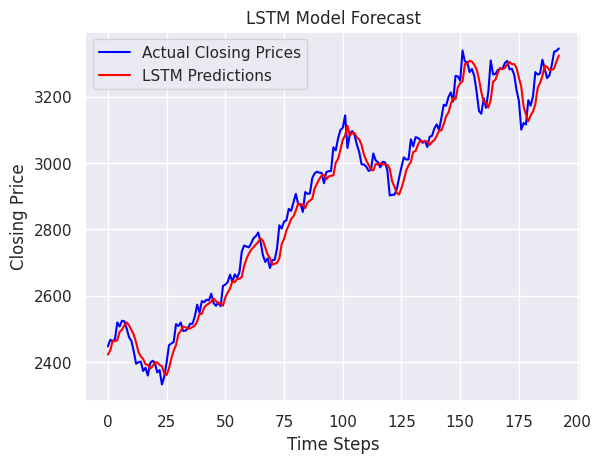

In [105]:
plt.plot(y_test_inv, label='Actual Closing Prices', color='blue')
plt.plot(y_pred_inv, label='LSTM Predictions', color='red')
plt.title('LSTM Model Forecast')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

##Model Conclusion

In [106]:
table = {"MODEL":pd.Series(["arima","sarimax","linear","Holt_winter","Quadratic","LSTM"]),"RMSE_Values":pd.Series([rmse_arima,sarima_rmse, rmse_linear,rmse_exp,rmse_quad,rmse_lstm])}
table_rmse=pd.DataFrame(table)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
3,Holt_winter,0.141440
2,linear,0.259167
5,LSTM,39.495974
0,arima,215.413036
1,sarimax,218.479114
4,Quadratic,325.987918


#Final models for deployment

##Future Prediction using LSTM model

In [107]:
future_data=data_scaled[-order_length:].reshape((1,order_length,1))
forecast=[]

for i in range(50):
  prediction=LSTM_model.predict(future_data)
  forecast.append(prediction[0,0])
  future_data=np.append(future_data[:, 1:, :],prediction.reshape(1, 1, 1),axis=1)
  forecast_inv = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))
  last_date=data3.index.max()
  forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=50, freq='D')

1/1 [==============================] - 0s 19ms/step


In [108]:
forecast_inv.shape,forecast_dates.shape


((50, 1), (50,))

In [109]:
Forecast_df=pd.DataFrame({'Date': forecast_dates, 'Close': forecast_inv.flatten()})
print(Forecast_df)

         Date        Close
0  2023-11-21  3342.840088
1  2023-11-22  3351.559570
2  2023-11-23  3356.870361
3  2023-11-24  3361.926758
4  2023-11-25  3366.598145
5  2023-11-26  3372.666748
6  2023-11-27  3378.553467
7  2023-11-28  3384.538818
8  2023-11-29  3390.752930
9  2023-11-30  3397.339844
10 2023-12-01  3404.138184
11 2023-12-02  3411.190430
12 2023-12-03  3418.538086
13 2023-12-04  3426.205566
14 2023-12-05  3434.190430
15 2023-12-06  3442.517090
16 2023-12-07  3451.208008
17 2023-12-08  3460.287598
18 2023-12-09  3469.777832
19 2023-12-10  3479.705566
20 2023-12-11  3490.099365
21 2023-12-12  3500.992432
22 2023-12-13  3512.417236
23 2023-12-14  3524.411133
24 2023-12-15  3537.016357
25 2023-12-16  3550.277588
26 2023-12-17  3564.194092
27 2023-12-18  3578.816162
28 2023-12-19  3594.218506
29 2023-12-20  3610.459717
30 2023-12-21  3627.603516
31 2023-12-22  3645.725342
32 2023-12-23  3664.912109
33 2023-12-24  3685.258301
34 2023-12-25  3706.868896
35 2023-12-26  3729.863037
3

In [110]:
Forecast_df

,Date,Close
0,2023-11-21,3342.840088
1,2023-11-22,3351.559570
2,2023-11-23,3356.870361
3,2023-11-24,3361.926758
4,2023-11-25,3366.598145
5,2023-11-26,3372.666748
6,2023-11-27,3378.553467
7,2023-11-28,3384.538818
8,2023-11-29,3390.752930
9,2023-11-30,3397.339844


In [111]:
final_data=Forecast_df.copy()
final_file = "Forecast_df.csv"
final_data.to_csv(final_file, index=False)
print("final file saved as", final_file)

final file saved as Forecast_df.csv


##Future Prediction using Holt-Winter's exponential Method

In [112]:
forecast_length = 30
forecast_index = pd.date_range(start=test_data.index[-1], periods=forecast_length, freq='B')
# Forecast the next 30 values using the trained model
forecast_exp = HWmodel_fit.forecast(forecast_length)
forecast_df2 = pd.DataFrame({'Date': forecast_index, 'Forecasted_Value': forecast_exp})
forecast_df2.set_index('Date', inplace=True)

In [113]:
forecast_df2

,Forecasted_Value
Date,
2023-11-20,7.898914
2023-11-21,7.902277
2023-11-22,7.902200
2023-11-23,7.904253
2023-11-24,7.902848
2023-11-27,7.905452
2023-11-28,7.909559
2023-11-29,7.913260
2023-11-30,7.914630


In [114]:
forecast_df2['Forecasted_Value'] = np.exp(forecast_df2['Forecasted_Value'])
forecast_df2.reset_index(inplace=True)

In [115]:
forecast_df2

,Date,Forecasted_Value
0,2023-11-20,2694.353705
1,2023-11-21,2703.430875
2,2023-11-22,2703.221835
3,2023-11-23,2708.778386
4,2023-11-24,2704.974559
5,2023-11-27,2712.027534
6,2023-11-28,2723.188524
7,2023-11-29,2733.287565
8,2023-11-30,2737.033367
9,2023-12-01,2729.856764


In [116]:
final_data=forecast_df2.copy()
final_file = "forecast_df2.csv"
final_data.to_csv(final_file, index=False)
print("final file saved as", final_file)

final file saved as forecast_df2.csv


In [117]:
"""
import pickle
filename = 'exponential_smoothing_model.pkl'

# Save the trained model to the pickle file
with open(filename, 'wb') as file:
    pickle.dump(HWmodel_fit, file)

print("Model saved to", filename)
"""

'\nimport pickle\nfilename = \'exponential_smoothing_model.pkl\'\n\n# Save the trained model to the pickle file\nwith open(filename, \'wb\') as file:\n    pickle.dump(HWmodel_fit, file)\n\nprint("Model saved to", filename)\n'

In [118]:
"""
import pickle
filename = 'exponential_smoothing_model.pkl'

# Save the trained model to the pickle file
with open(filename, 'wb') as file:
    pickle.dump(LSTM_model, file)

print("Model saved to", filename)
"""

'\nimport pickle\nfilename = \'exponential_smoothing_model.pkl\'\n\n# Save the trained model to the pickle file\nwith open(filename, \'wb\') as file:\n    pickle.dump(LSTM_model, file)\n\nprint("Model saved to", filename)\n'

In [119]:
#csv_file_path=r"C:\Users\ACER\Documents\project\forecast_df2.csv"

In [120]:
#forecast_df2.to_csv(csv_file_path, index=False)